### SMA Backtesting 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

#### Load the example CSV file using pandas

In [4]:
raw = (
    pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv')
    .assign(Date=lambda x: pd.to_datetime(x['Date']))
    .dropna()
)

In [5]:
raw.head(5)

,Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
1,2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2,2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
3,2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
4,2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
5,2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


#### Taking the euro column of the raw data, converting it to a dataframe

In [6]:
data = pd.DataFrame(raw['EUR=']).rename(columns={'EUR=': 'price'})

SMA, or Simple Moving Average, trading strategies often utilize 42 and 252-day periods due to specific reasons related to the financial markets:

252-Day SMA: This period is commonly used because there are approximately 252 trading days in a year for the stock market. Therefore, a 252-day SMA represents a moving average over the past year. This annual perspective is crucial for long-term trend analysis, as it smooths out short-term fluctuations and provides a broader view of the market trend.

42-Day SMA: The 42-day period, roughly equivalent to two months of trading days, is often used for a shorter-term analysis. It helps traders to identify medium-term trends and can be more responsive to recent price changes than the longer 252-day SMA. This shorter period can be useful for identifying potential entry and exit points for medium-term trading strategies.

These specific time frames are chosen to represent different aspects of market behavior: short-term (42-day) for more recent trend movements and long-term (252-day) for more stable, overarching trends. By analyzing both, traders can get a more comprehensive understanding of market trends and make more informed trading decisions.

It's important to note that while 42 and 252 days are common, they are not the only periods used. Traders often tailor SMA periods to fit their specific trading strategies, risk tolerance, and investment goals. Other popular periods include 50-day, 100-day, and 200-day SMAs, each offering a different perspective on market trends.

In [7]:
# Getting the rolling mean of the past N days by assigning them to new columns
data['SMA1'] = data['price'].rolling(42).mean()

data['SMA2'] = data['price'].rolling(252).mean()

In [8]:
data.tail(10)

,price,SMA1,SMA2
2597,1.1149,1.108155,1.120211
2598,1.1111,1.108017,1.120112
2599,1.1120,1.107950,1.120011
2600,1.1078,1.107840,1.119865
2601,1.1086,1.107738,1.119754
2602,1.1087,1.107698,1.119630
2604,1.1096,1.107740,1.119529
2605,1.1175,1.107924,1.119428
2606,1.1197,1.108131,1.119333
2607,1.1210,1.108279,1.119231


#### Plotting the time series of price using Seaborn 

*Remark: the plot is stationary*

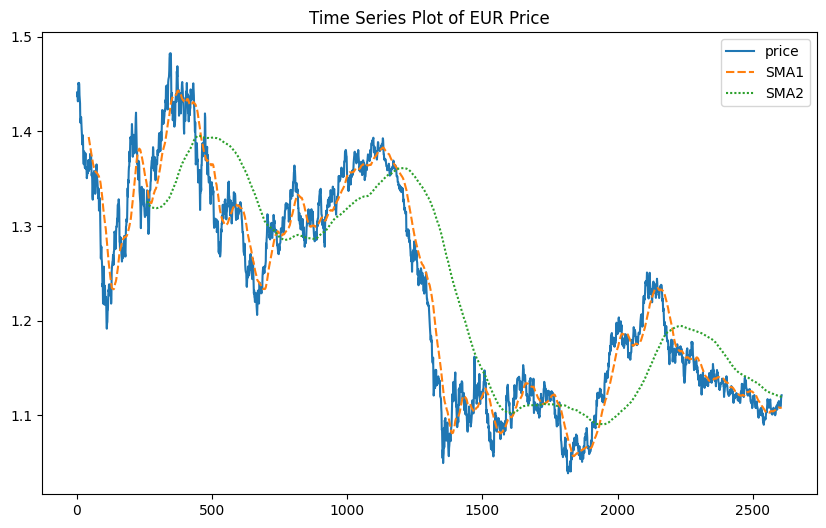

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data)
plt.title('Time Series Plot of EUR Price')
plt.show()

#### Making it interactive using Plotly

In [10]:
fig = go.Figure()

# Assuming 'data' is a pandas DataFrame
legend_names = ['Original', 'SMA1', 'SMA2']  # replace with your legend names
for i, col in enumerate(data.columns):
    fig.add_trace(go.Scatter(
        y=data[col],
        mode='lines',
        name=legend_names[i],  # use the legend names here
    ))

fig.update_layout(
    title={
        'text': 'Time Series of EUR Price',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

SMA1 would be a shorter-term moving average (e.g., a 42-day SMA), and SMA2 would be a longer-term moving average.

When SMA1 > SMA2 (Position = 1): This suggests that the short-term trend is stronger than the long-term trend, potentially indicating an upward or bullish market movement. The strategy dictates taking a long position (buying the asset) in this scenario.

When SMA1 < SMA2 (Position = -1): This suggests that the short-term trend is weaker than the long-term trend, potentially indicating a downward or bearish market movement. The strategy dictates taking a short position (selling the asset) in this scenario.

In essence, this trading strategy assumes that when the short-term trend deviates significantly from the long-term trend, it's an opportunity to make a profit by either buying or selling the asset, depending on the direction of the deviation.


In [11]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data.dropna(inplace=True)

In [12]:
px.line(data, y=['position'], title='EUR Price/SMA Crossover Strategy')

#### Taking the log return to get the performance of the strategy

In [13]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [15]:
fig = px.histogram(data, x='returns', nbins=50, title='EUR Returns Distribution')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title_text='EUR Returns Distribution', # title of plot
    xaxis_title_text='Return', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

By creating the data['strategy'] column in this way, you are effectively simulating the performance of your trading strategy based on historical data. It shows what would have happened if you had followed the moving average crossover signals to take long or short positions, taking into account a one-day delay between signal and action

In [16]:
data['strategy'] = data['position'].shift(1) * data['returns']

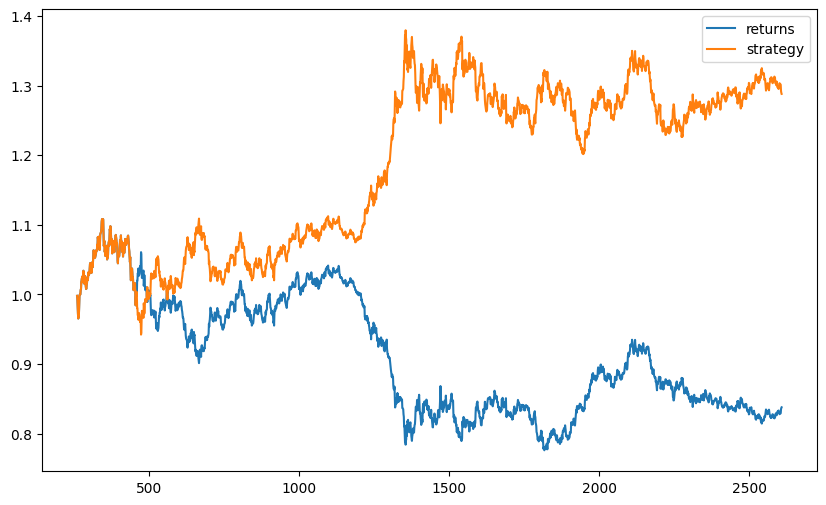

In [17]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));